In [9]:
!pip install --user --upgrade apafib

In [40]:
from apafib import load_literature

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate


# Apartado A

Para este apartado se pide transformar los textos en matrices bag-of-words con CountVectorizer, donde se representa si aparece o no las palabras en los diferentes documentos. 

Generaremos cuatro variantes: vocabularios de 250 y 500 términos, cada uno en modo binario (presencia/ausencia) y en conteos, eliminando stop words en inglés. Todo el preproceso se aplicará correctamente con una partición estratificada 80/20 y semilla fija para reproducibilidad.

load_literature() contiene una lista con los textos y otra con las etiquetas que le corresponden.

In [22]:
texts, labels = load_literature()
label = np.array(labels)

#particion 80%-20%
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.20, stratify=labels, random_state=42
)

Fijamos el tamaño del vocabulario con el parámetro max_features de CountVectorizer, usando 250 y 500 términos como indica el enunciado.

In [23]:
# 250 términos, binario (presencia/ausencia)
vec_bin_250 = CountVectorizer(stop_words='english', max_features=250, binary=True)
Xtr_bin_250 = vec_bin_250.fit_transform(X_train_texts)
Xte_bin_250 = vec_bin_250.transform(X_test_texts)

# 500 términos, con conteos
vec_cnt_500 = CountVectorizer(stop_words='english', max_features=500, binary=False)
Xtr_cnt_500 = vec_cnt_500.fit_transform(X_train_texts)
Xte_cnt_500 = vec_cnt_500.transform(X_test_texts)

# 250 términos con conteos
vec_cnt_250 = CountVectorizer(stop_words='english', max_features=250, binary=False)
Xtr_cnt_250 = vec_cnt_250.fit_transform(X_train_texts)
Xte_cnt_250 = vec_cnt_250.transform(X_test_texts)

# 500 términos en binario
vec_bin_500 = CountVectorizer(stop_words='english', max_features=500, binary=True)
Xtr_bin_500 = vec_bin_500.fit_transform(X_train_texts)
Xte_bin_500 = vec_bin_500.transform(X_test_texts)



Obtenemos cuatro conjuntos de datos porque combinamos dos tamaños de vocabulario (250 y 500 términos) con dos representaciones distintas (binaria presencia/ausencia y conteos). Así generamos: 250‑count, 500‑count, 250‑binary y 500‑binary, todos con stop_words='english'. Cada variante se ajusta en train y se aplica en test (split estratificado 80/20), produciendo cuatro matrices X_train/X_test diferentes.

# Apartado B

Trabajamos con matrices muy dispersas, de altísima dimensión y con relaciones no lineales entre documentos. Esto hace que una proyección lineal como PCA en 2D resulta poco informativa.
Por ello utilizamos t‑SNE, un método no lineal que preserva vecindades locales y resulta más adecuado para explorar posibles agrupaciones.

Para estabilizar y acelerar t‑SNE, primero reducimos la dimensión con TruncatedSVD (equivalente a PCA para datos dispersos) y después aplicamos t‑SNE en 2D, probando varios valores de perplexity y fijando una semilla para reproducibilidad. Usamos métrica coseno (más apropiada en texto) y coloreamos por la clase objetivo.

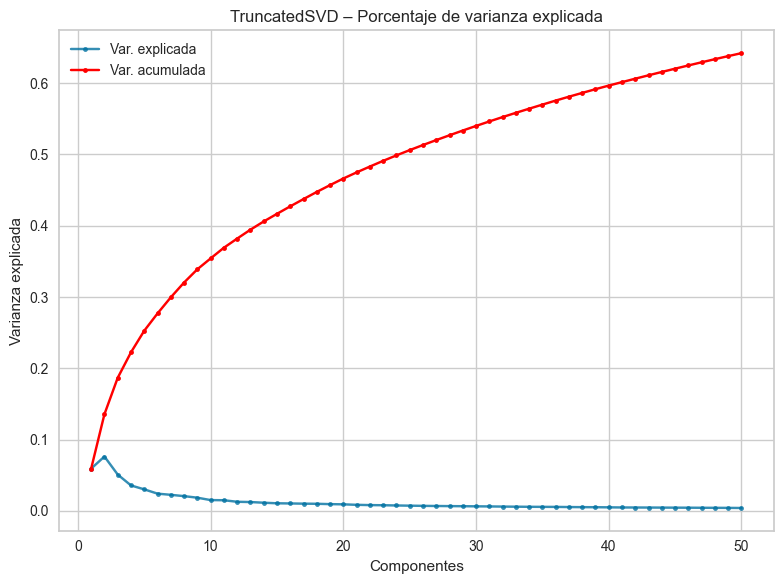

In [24]:
Xtr = Xtr_cnt_500      # matriz sparse (train)
ytr = np.array(y_train)


svd = TruncatedSVD(n_components=50, random_state=42)
Xtr_svd = svd.fit_transform(Xtr)

# Curva de varianza explicada 
fig = plt.figure(figsize=(8,6))
plt.plot(range(1, len(svd.explained_variance_ratio_)+1),
         svd.explained_variance_ratio_, marker='.', alpha=0.8, label='Var. explicada')
plt.plot(range(1, len(svd.explained_variance_ratio_)+1),
         np.cumsum(svd.explained_variance_ratio_), marker='.', color='red',
         label='Var. acumulada')
plt.xlabel('Componentes')
plt.ylabel('Varianza explicada')
plt.title('TruncatedSVD – Porcentaje de varianza explicada')
plt.legend()
plt.tight_layout()

La curva de varianza explicada de TruncatedSVD muestra que cada componente aporta muy poco y que, incluso con 50 componentes, la varianza acumulada ronda el 60–65%. Esto confirma que los textos bag‑of‑words presentan estructura de alta dimensión y que una proyección lineal a 2D no captura bien la información. Por ello, reducimos primero a 50 dimensiones con SVD y aplicamos t‑SNE para preservar vecindarios locales y explorar posible separabilidad entre épocas/autores.

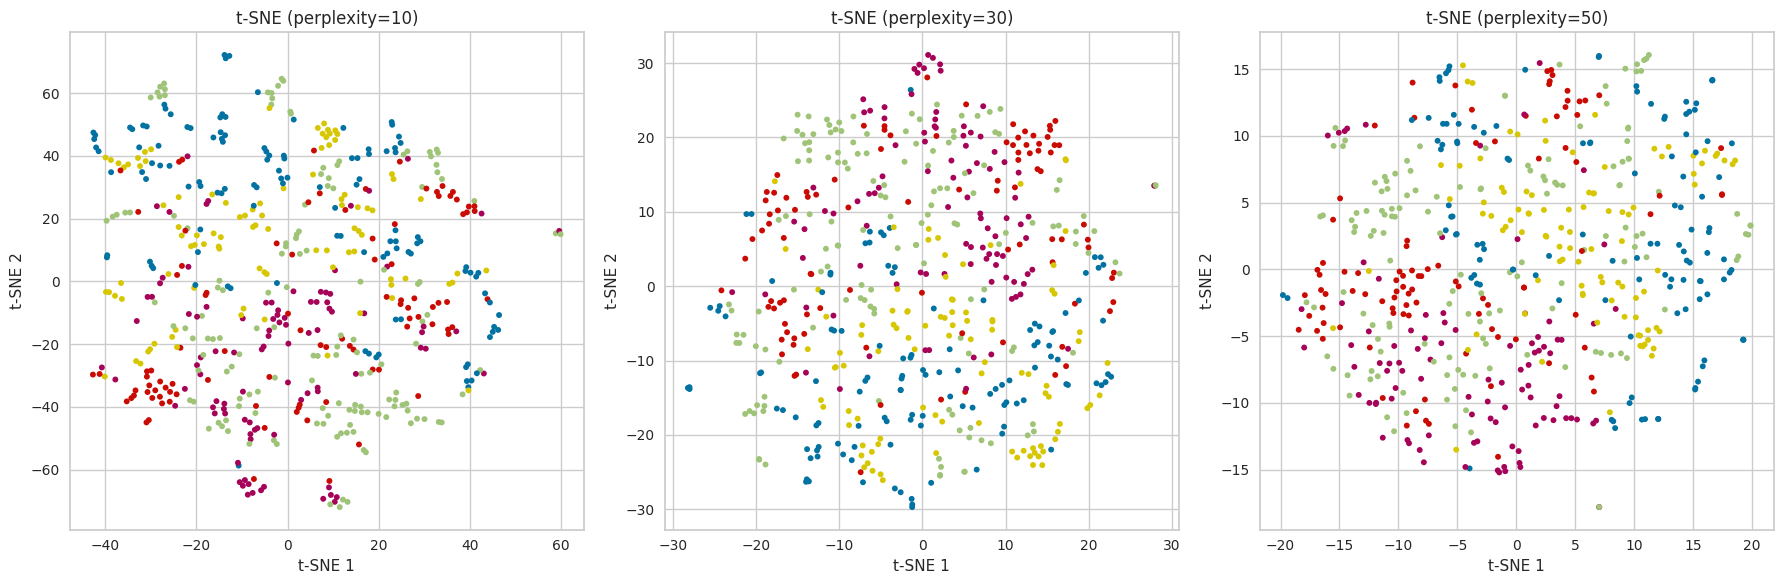

In [32]:
ytr = pd.Series(ytr, name="target")

X_svd_std = StandardScaler().fit_transform(Xtr_svd)

mpl.rcParams['font.family'] = 'DejaVu Sans'

perplexities = [10, 30, 50]
fig, axes = plt.subplots(1, len(perplexities), figsize=(18,6))

for ax, p in zip(axes, perplexities):
    tsne = TSNE(
        n_components=2,
        perplexity=p,
        max_iter=2000,          
        init='pca',
        learning_rate='auto',
        metric='cosine',        # mejor para texto
        random_state=42
    )
    X_tsne = tsne.fit_transform(X_svd_std)

    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=ytr, s=18, linewidth=0, ax=ax, legend=False)
    ax.set_title(f"t-SNE (perplexity={p})")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

Para los valores de perplexity altos hay una mayor énfasis la estructura global, en cambio para valores más pequeños se enfatiza vecindades locales. 

En nuestra proyección t-SNE en 2D no se observa separabilidad clara por clase, los puntos de distintos colores se solapan ampliamente para los tres valores de perplexity, por lo que solo hay separabilidad parcial. Esto puede deberse a que existen muchas palabras compartidas entre diferentes autores lo que genera vectores muy similares. Una posible mejora podría ser evaluar con TF-IDF en vez de conteos para tener en cuenta la similitud entre textos.



# Apartado C

Para este apartado vamos a clasificar los textos con modelos Naïve Bayes aprovechando la representación bag‑of‑words que construimos antes. Para ello supondremos que las palabras de un texto son independientes.
Se emplearan los siguientes modelos:

- Bernoulli apropiado para vectores binarios (presencia/ausencia)
- Naïve Bayes apropiado para vectores de conteo

## BernoulliNB
Vamos a empezar aplicando el método de Bernoulli sobre los dos conjuntos binarios que hemos obtenido anteriormente (Xtr_bin_250, Xte_bin_250, Xtr_bin_500, Xte_bin_500, y_train, y_test)


===== BernoulliNB [bin_250] =====
Mejor alpha (CV 10-fold, F1 macro): 5.0  |  F1_macro_CV = 0.568
Test Accuracy = 0.543 | Test F1_macro = 0.524

              precision    recall  f1-score   support

        16th      0.667     0.833     0.741        24
        17th      0.486     0.600     0.537        30
        18th      0.538     0.194     0.286        36
        19th      0.368     0.292     0.326        24
        20th      0.590     0.958     0.730        24

    accuracy                          0.543       138
   macro avg      0.530     0.576     0.524       138
weighted avg      0.529     0.543     0.504       138



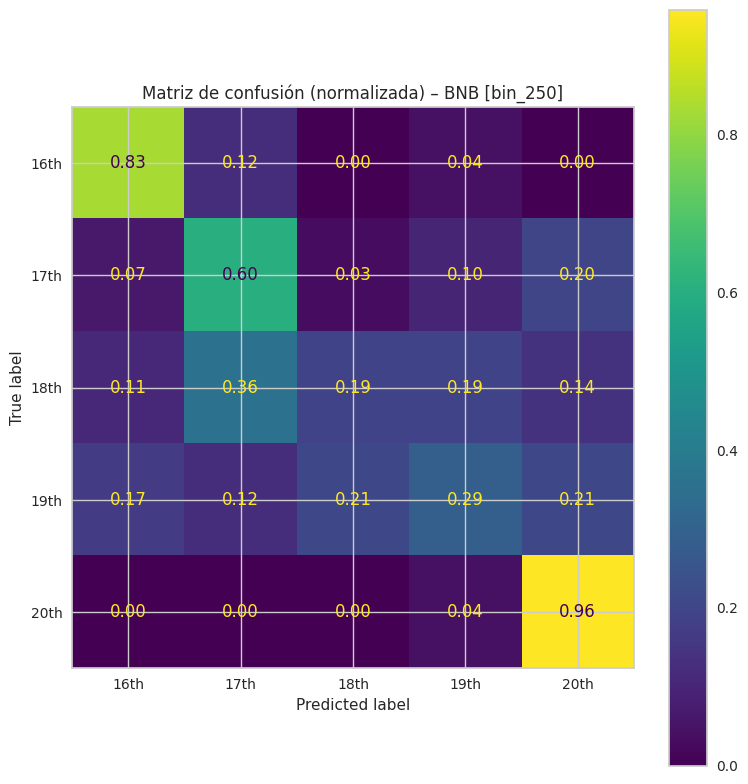


===== BernoulliNB [bin_500] =====
Mejor alpha (CV 10-fold, F1 macro): 0.1  |  F1_macro_CV = 0.638
Test Accuracy = 0.630 | Test F1_macro = 0.627

              precision    recall  f1-score   support

        16th      0.808     0.875     0.840        24
        17th      0.647     0.733     0.688        30
        18th      0.538     0.389     0.452        36
        19th      0.381     0.333     0.356        24
        20th      0.710     0.917     0.800        24

    accuracy                          0.630       138
   macro avg      0.617     0.649     0.627       138
weighted avg      0.611     0.630     0.614       138



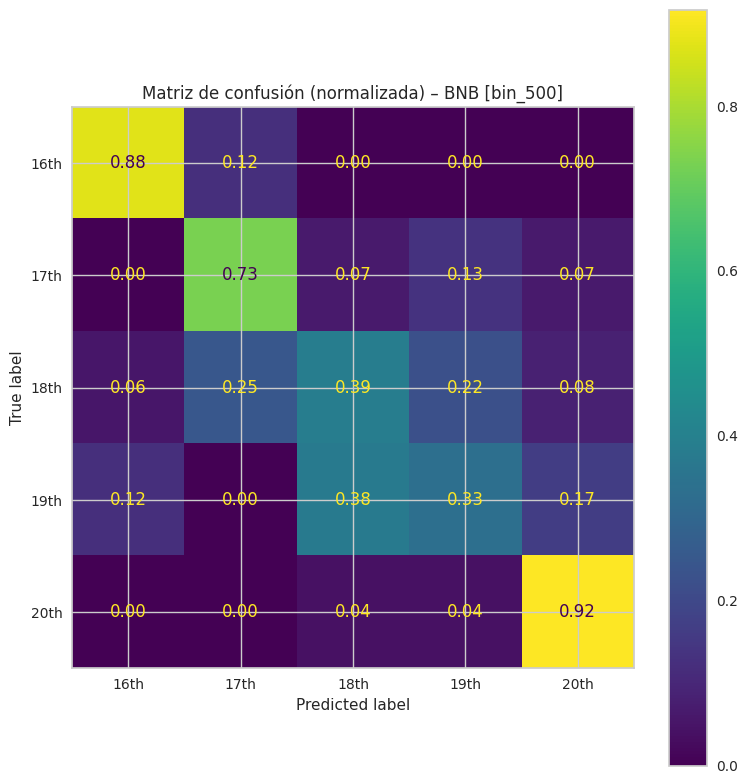


Resumen (F1 macro en test):
- BNB [bin_250]: 0.524
- BNB [bin_500]: 0.627
Mejor representación (según F1 macro test): bin_500


In [60]:
def run_bernoulli_nb(X_train, y_train, X_test, y_test, dataset_name, class_names=None, results_df=None):
    y_tr = np.ravel(y_train)
    y_te = np.ravel(y_test)
    
    # CV estratificada y reproducible
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Búsqueda de alpha 
    param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
    gcv = GridSearchCV(
        estimator=BernoulliNB(),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        refit=True,           # reentrena con el mejor alpha en todo el train
        return_train_score=False
    )
    gcv.fit(X_train, y_tr)

    best_alpha = gcv.best_params_['alpha']
    cv_f1 = gcv.best_score_

    
    bnb_best = gcv.best_estimator_
    y_pred = bnb_best.predict(X_test)

    test_acc = accuracy_score(y_te, y_pred)
    test_f1m = f1_score(y_te, y_pred, average='macro')

    print(f"\n===== BernoulliNB [{dataset_name}] =====")
    print(f"Mejor alpha (CV 10-fold, F1 macro): {best_alpha}  |  F1_macro_CV = {cv_f1:.3f}")
    print(f"Test Accuracy = {test_acc:.3f} | Test F1_macro = {test_f1m:.3f}\n")

    print(classification_report(y_te, y_pred, target_names=class_names, digits=3))

    # Matriz de confusión 
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred,
        display_labels=class_names,
        normalize='true',
        values_format=".2f",
        ax=ax
    )
    ax.set_title(f"Matriz de confusión (normalizada) – BNB [{dataset_name}]")
    plt.tight_layout()
    plt.show()
    return {
        'model': bnb_best,
        'best_alpha': best_alpha,
        'cv_f1_macro': cv_f1,
        'test_accuracy': test_acc,
        'test_f1_macro': test_f1m
    }


cls = [str(v) for v in sorted(np.unique(np.concatenate([np.ravel(y_train), np.ravel(y_test)])))]

results_250 = run_bernoulli_nb(Xtr_bin_250, y_train, Xte_bin_250, y_test, "bin_250", class_names=cls)
results_500 = run_bernoulli_nb(Xtr_bin_500, y_train, Xte_bin_500, y_test, "bin_500", class_names=cls)

print("\nResumen (F1 macro en test):")
print(f"- BNB [bin_250]: {results_250['test_f1_macro']:.3f}")
print(f"- BNB [bin_500]: {results_500['test_f1_macro']:.3f}")
best = "bin_500" if results_500['test_f1_macro'] >= results_250['test_f1_macro'] else "bin_250"
print(f"Mejor representación (según F1 macro test): {best}")

Comparando vocabularios de 250 y 500 términos, la representación bin_500 obtiene mejores resultados:
- F1 macro test: 0.524 → 0.627 (+0.10)
- Accuracy test: 0.543 → 0.630 (+0.09)
- Las métricas de CV (F1 macro 0.568 y 0.638, respectivamente) son coherentes con test, indicando estabilidad.

También se puede ver que con 250 términos el mejor alfa es alto (5.0), en cambio con 500 términos el mejor es bajo (0.1), lo que indica que hay más señales discriminativas y menos necesidad de suavizar.
Podemos observar que las clases mejor resultas son 16th y 20th, las cuales contendrán un léxico más destintivo. Además en bin_250, 20th tiene recall altísimo (0.958) pero precisión baja (0.590), el modelo sobrepredice “20th” (última columna con muchos falsos positivos), lo que se corrige parcialmente con 500 términos.

## MultinomialNB

A continuación, se aplica el método MultinomialNB sobre los conjuntos de conteo que hemos obtenido en el apartado A, (Xtr_cnt_250, Xte_cnt_250, Xtr_cnt_500, Xte_cnt_500)


===== MultinomialNB [cnt_250] =====
Mejor alpha (CV 10-fold, F1 macro): 0.05 | F1_macro_CV = 0.626
Test Accuracy = 0.587 | Test F1_macro = 0.583

              precision    recall  f1-score   support

        16th      0.760     0.792     0.776        24
        17th      0.512     0.700     0.592        30
        18th      0.684     0.361     0.473        36
        19th      0.474     0.375     0.419        24
        20th      0.559     0.792     0.655        24

    accuracy                          0.587       138
   macro avg      0.598     0.604     0.583       138
weighted avg      0.602     0.587     0.574       138



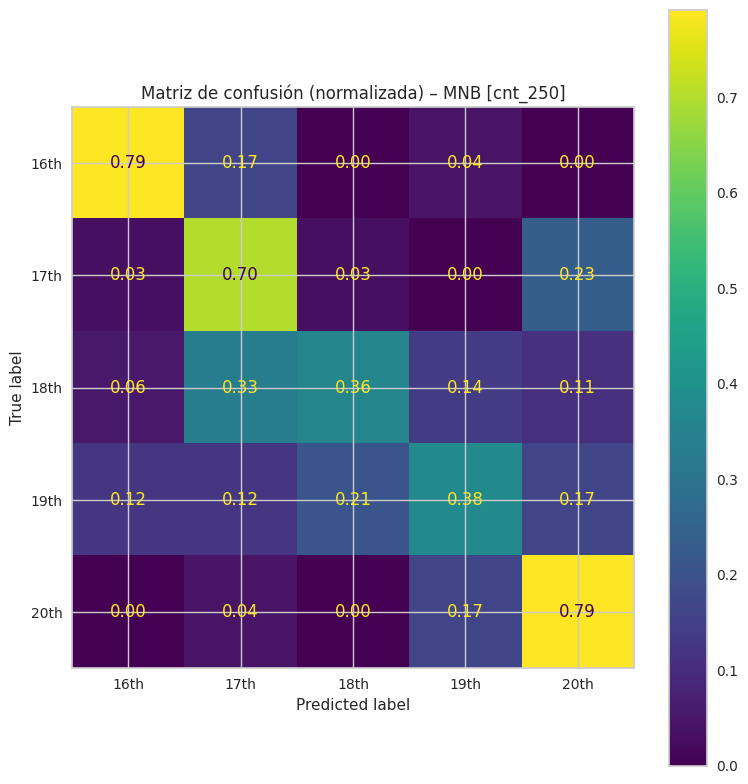


===== MultinomialNB [cnt_500] =====
Mejor alpha (CV 10-fold, F1 macro): 0.1 | F1_macro_CV = 0.703
Test Accuracy = 0.681 | Test F1_macro = 0.682

              precision    recall  f1-score   support

        16th      0.840     0.875     0.857        24
        17th      0.733     0.733     0.733        30
        18th      0.714     0.556     0.625        36
        19th      0.462     0.500     0.480        24
        20th      0.655     0.792     0.717        24

    accuracy                          0.681       138
   macro avg      0.681     0.691     0.682       138
weighted avg      0.686     0.681     0.680       138



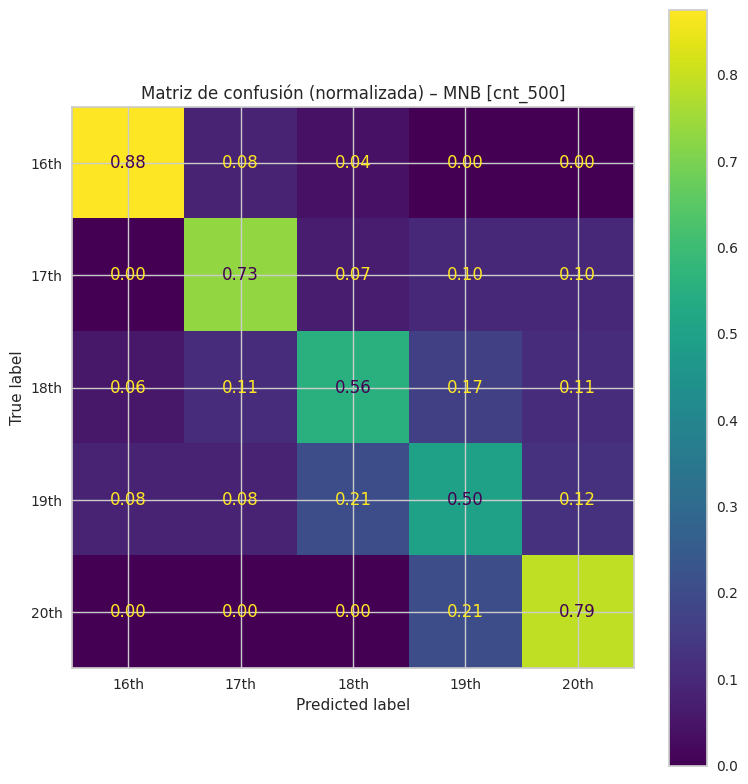

In [59]:
def run_multinomial_nb(X_train, y_train, X_test, y_test, dataset_name, class_names=None):
    y_tr = np.ravel(y_train)
    y_te = np.ravel(y_test)
    if class_names is None:
        class_names = [str(v) for v in sorted(np.unique(np.concatenate([y_tr, y_te])))]

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    param_grid = {'alpha': [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
    gcv = GridSearchCV(
        MultinomialNB(),
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gcv.fit(X_train, y_tr)

    best_alpha = gcv.best_params_['alpha']
    cv_f1 = gcv.best_score_

    mnb_best = gcv.best_estimator_
    y_pred = mnb_best.predict(X_test)

    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average='macro')

    print(f"\n===== MultinomialNB [{dataset_name}] =====")
    print(f"Mejor alpha (CV 10-fold, F1 macro): {best_alpha} | F1_macro_CV = {cv_f1:.3f}")
    print(f"Test Accuracy = {acc:.3f} | Test F1_macro = {f1m:.3f}\n")
    print(classification_report(y_te, y_pred, target_names=class_names, digits=3))

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred, display_labels=class_names,
        normalize='true', values_format=".2f", ax=ax
    )
    ax.set_title(f"Matriz de confusión (normalizada) – MNB [{dataset_name}]")
    plt.tight_layout(); plt.show()

    return {'model': mnb_best, 'best_alpha': best_alpha, 'cv_f1_macro': cv_f1,
            'test_accuracy': acc, 'test_f1_macro': f1m}

cls = [str(v) for v in sorted(np.unique(np.concatenate([np.ravel(y_train), np.ravel(y_test)])))]

res_mnb_cnt250 = run_multinomial_nb(Xtr_cnt_250, y_train, Xte_cnt_250, y_test, "cnt_250", class_names=cls)
res_mnb_cnt500 = run_multinomial_nb(Xtr_cnt_500, y_train, Xte_cnt_500, y_test, "cnt_500", class_names=cls)


Con conteos, los alpha óptimos son pequeños (0.05–0.10), esto se puede deber a que la frecuencia de términos ofrece suficiente evidencia y apenas se requiere suavizar.
Al ampliar a 500 términos, hay más rasgos informativos y mejora de forma consistente todas las métricas.

Las clases 16th y 20th siguen siendo las más fáciles. Con cnt_500 alcanzan F1≈0.86 y 0.72, con recalls 0.875 y 0.792 respectivamente.
Se puede observar una ganancia clara de MultinomialNB, especialmente en 18th y 19th, donde la información de frecuencia (no solo presencia/ausencia) ayuda a diferenciar estilos léxicos cercanos.

Podemos concluir diciendo que el mejor método hasta ahora es MultinomialNB con vocabulario de 500 términos y alpha = 0.1. Capturar la frecuencia de aparición de palabras resulta decisivo para separar mejor los siglos intermedios.

# Apartado D
Para este último apartado vamos a ajustar un modelo de regresión logística a los conjuntos de datos que hemos generado anteriormente, explorando hiperparámetros del modelo y determinando la calidad de los mejores modelos.





===== Logistic Regression [bin_250] =====
Mejores hiperparámetros: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
F1_macro_CV = 0.652 | Test Accuracy = 0.710 | Test F1_macro = 0.701

              precision    recall  f1-score   support

        16th      0.679     0.792     0.731        24
        17th      0.774     0.800     0.787        30
        18th      0.694     0.694     0.694        36
        19th      0.556     0.417     0.476        24
        20th      0.800     0.833     0.816        24

    accuracy                          0.710       138
   macro avg      0.701     0.707     0.701       138
weighted avg      0.703     0.710     0.704       138



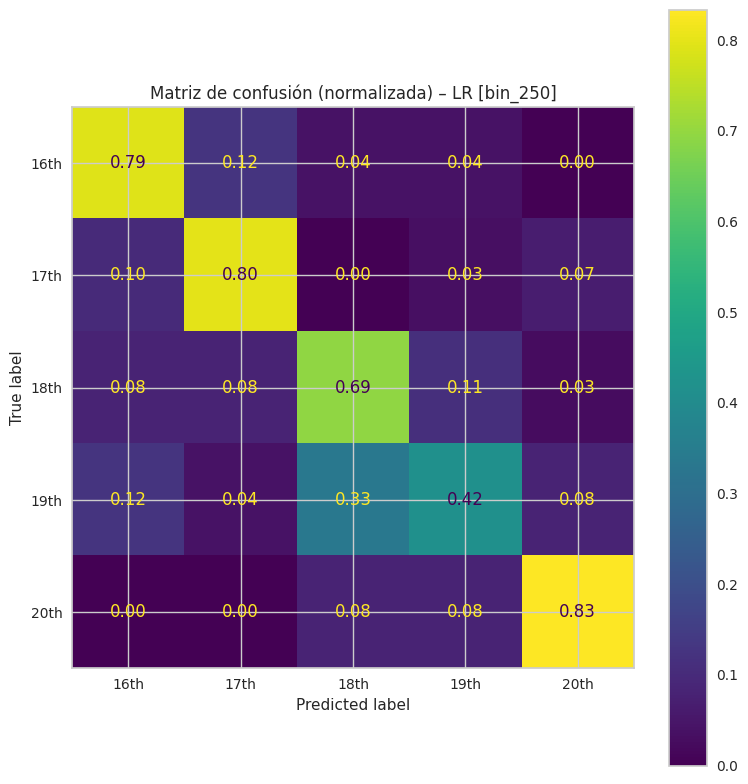


===== Logistic Regression [bin_500] =====
Mejores hiperparámetros: {'clf__C': 0.5, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
F1_macro_CV = 0.750 | Test Accuracy = 0.804 | Test F1_macro = 0.797

              precision    recall  f1-score   support

        16th      0.786     0.917     0.846        24
        17th      0.867     0.867     0.867        30
        18th      0.732     0.833     0.779        36
        19th      0.750     0.500     0.600        24
        20th      0.913     0.875     0.894        24

    accuracy                          0.804       138
   macro avg      0.809     0.798     0.797       138
weighted avg      0.805     0.804     0.799       138



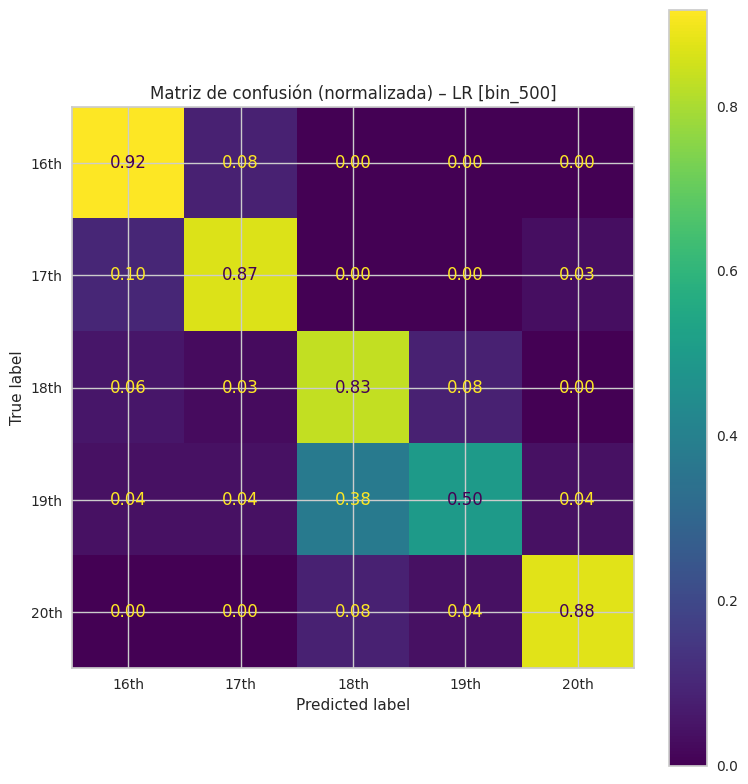


===== Logistic Regression [cnt_250] =====
Mejores hiperparámetros: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
F1_macro_CV = 0.722 | Test Accuracy = 0.703 | Test F1_macro = 0.701

              precision    recall  f1-score   support

        16th      0.636     0.583     0.609        24
        17th      0.647     0.733     0.688        30
        18th      0.700     0.778     0.737        36
        19th      0.682     0.625     0.652        24
        20th      0.900     0.750     0.818        24

    accuracy                          0.703       138
   macro avg      0.713     0.694     0.701       138
weighted avg      0.709     0.703     0.703       138



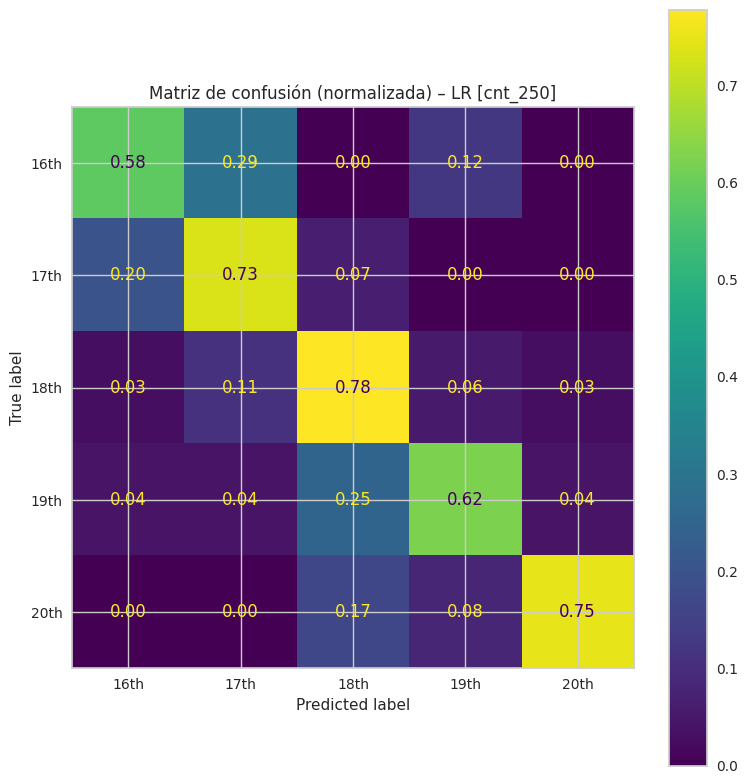


===== Logistic Regression [cnt_500] =====
Mejores hiperparámetros: {'clf__C': 10.0, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
F1_macro_CV = 0.794 | Test Accuracy = 0.717 | Test F1_macro = 0.723

              precision    recall  f1-score   support

        16th      0.842     0.667     0.744        24
        17th      0.676     0.767     0.719        30
        18th      0.634     0.722     0.675        36
        19th      0.714     0.625     0.667        24
        20th      0.826     0.792     0.809        24

    accuracy                          0.717       138
   macro avg      0.739     0.714     0.723       138
weighted avg      0.727     0.717     0.718       138



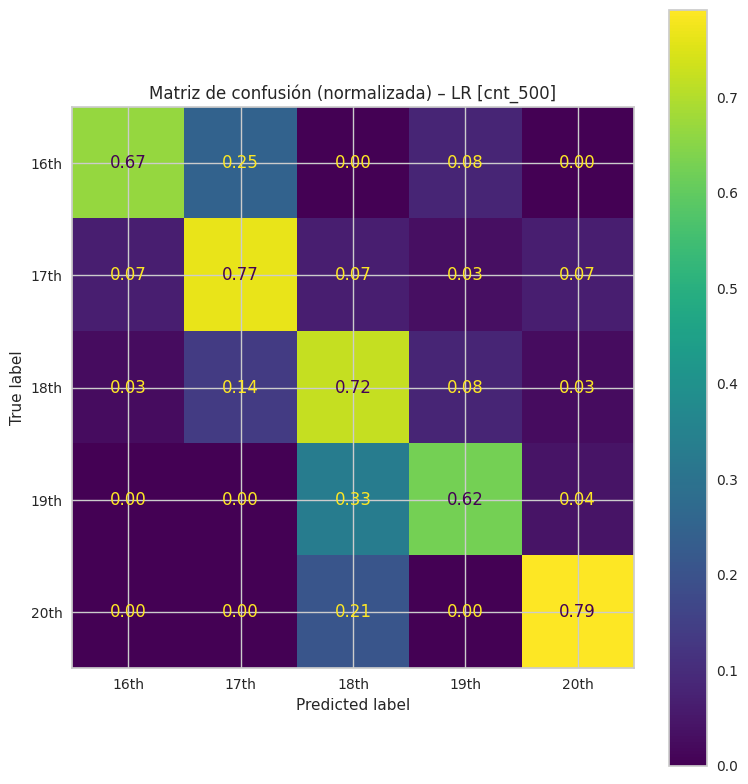


===== Logistic Regression [tfidf_250] =====
Mejores hiperparámetros: {'clf__C': 10.0, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
F1_macro_CV = 0.746 | Test Accuracy = 0.761 | Test F1_macro = 0.754

              precision    recall  f1-score   support

        16th      0.833     0.625     0.714        24
        17th      0.703     0.867     0.776        30
        18th      0.732     0.833     0.779        36
        19th      0.737     0.583     0.651        24
        20th      0.870     0.833     0.851        24

    accuracy                          0.761       138
   macro avg      0.775     0.748     0.754       138
weighted avg      0.768     0.761     0.757       138



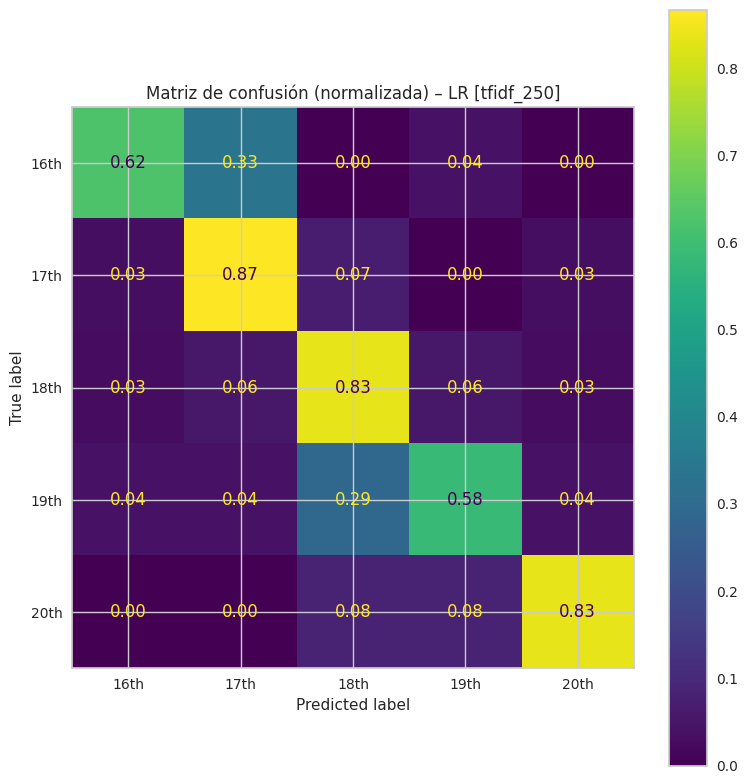


===== Logistic Regression [tfidf_500] =====
Mejores hiperparámetros: {'clf__C': 10.0, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
F1_macro_CV = 0.808 | Test Accuracy = 0.797 | Test F1_macro = 0.795

              precision    recall  f1-score   support

        16th      0.875     0.875     0.875        24
        17th      0.839     0.867     0.852        30
        18th      0.667     0.833     0.741        36
        19th      0.800     0.500     0.615        24
        20th      0.913     0.875     0.894        24

    accuracy                          0.797       138
   macro avg      0.819     0.790     0.795       138
weighted avg      0.806     0.797     0.793       138



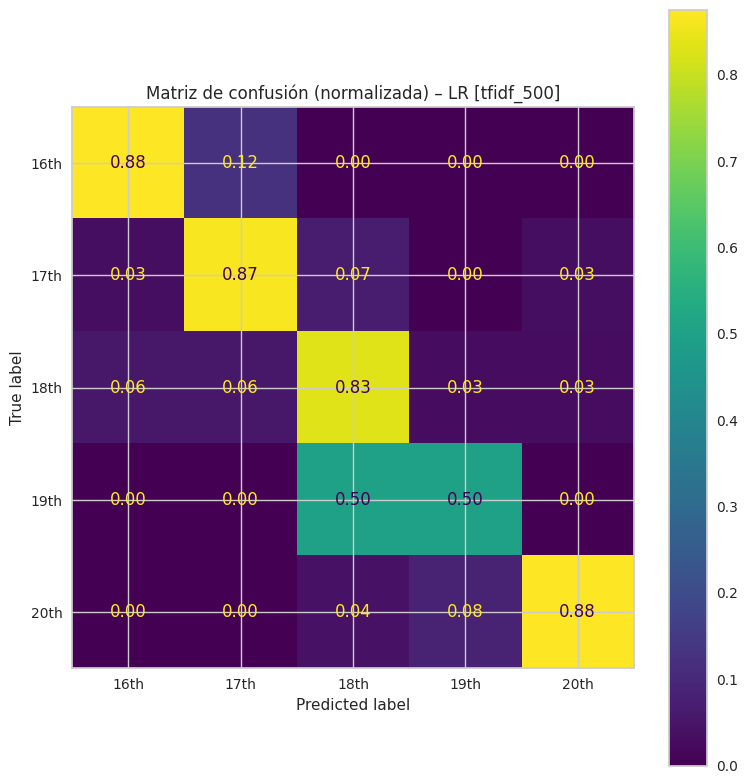

In [58]:

from sklearn.feature_extraction.text import TfidfTransformer

def run_logreg(
    X_train, y_train, X_test, y_test,
    dataset_name, class_names=None, use_tfidf=False
):
    y_tr = np.ravel(y_train)
    y_te = np.ravel(y_test)
    if class_names is None:
        class_names = [str(v) for v in sorted(np.unique(np.concatenate([y_tr, y_te])))]

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    if use_tfidf:
        pipe = Pipeline([
            ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l2', use_idf=True)),
            ('clf', LogisticRegression(max_iter=5000))
        ])
    else:
        pipe = Pipeline([
            ('clf', LogisticRegression(max_iter=5000))
        ])

    param_grid = [
        
        {
            'clf__penalty': ['l2'],
            'clf__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
            'clf__solver': ['lbfgs', 'saga'],
            'clf__class_weight': [None]  
        },
        
        {
            'clf__penalty': ['l1'],
            'clf__C': [0.5, 1.0, 2.0],
            'clf__solver': ['saga'],
            'clf__class_weight': [None]
        }
    ]

    gcv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gcv.fit(X_train, y_tr)

    best = gcv.best_estimator_
    y_pred = best.predict(X_test)

    acc = accuracy_score(y_te, y_pred)
    f1m = f1_score(y_te, y_pred, average='macro')

    print(f"\n===== Logistic Regression [{dataset_name}] =====")
    print("Mejores hiperparámetros:", gcv.best_params_)
    print(f"F1_macro_CV = {gcv.best_score_:.3f} | Test Accuracy = {acc:.3f} | Test F1_macro = {f1m:.3f}\n")
    print(classification_report(y_te, y_pred, target_names=class_names, digits=3))

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_te, y_pred, display_labels=class_names,
        normalize='true', values_format=".2f", ax=ax
    )
    ax.set_title(f"Matriz de confusión (normalizada) – LR [{dataset_name}]")
    plt.tight_layout(); plt.show()

    return {'estimator': best, 'cv_f1_macro': gcv.best_score_,
            'test_accuracy': acc, 'test_f1_macro': f1m}


cls = [str(v) for v in sorted(np.unique(np.concatenate([np.ravel(y_train), np.ravel(y_test)])))]


res_lr_bin250 = run_logreg(Xtr_bin_250, y_train, Xte_bin_250, y_test, "bin_250", class_names=cls, use_tfidf=False)
res_lr_bin500 = run_logreg(Xtr_bin_500, y_train, Xte_bin_500, y_test, "bin_500", class_names=cls, use_tfidf=False)

res_lr_cnt250 = run_logreg(Xtr_cnt_250, y_train, Xte_cnt_250, y_test, "cnt_250", class_names=cls, use_tfidf=False)
res_lr_cnt500 = run_logreg(Xtr_cnt_500, y_train, Xte_cnt_500, y_test, "cnt_500", class_names=cls, use_tfidf=False)


res_lr_tfidf250 = run_logreg(Xtr_cnt_250, y_train, Xte_cnt_250, y_test, "tfidf_250", class_names=cls, use_tfidf=True)
res_lr_tfidf500 = run_logreg(Xtr_cnt_500, y_train, Xte_cnt_500, y_test, "tfidf_500", class_names=cls, use_tfidf=True)



El rendimiento de la Regresión Logística es claramente superior al de Naïve Bayes y, dentro de RL, depende mucho de la representación, con vocabulario de 500 términos, el esquema binario obtiene el mejor resultado, seguido muy de cerca por TF‑IDF con 500 términos. Ambos superan con margen a las variantes de 250 términos y a los conteos puros. 
Las matrices de confusión muestran que 16th, 17th y 20th se clasifican con alta precisión y recall, mientras que 18th mejora notablemente frente a NB (recall ≈0.83 con bin_500/TF‑IDF_500) y 19th sigue siendo la clase más difícil, con la principal confusión 18th↔19th pese a una reducción respecto a modelos anteriores. 

El patrón de hiperparámetros es coherente, en binario se favorece más regularización (C pequeño–medio), y en TF‑IDF un C mayor rinde bien gracias a la normalización. En conteos, aunque la CV de 500 términos es alta, en test no escala igual, lo que explica que TF‑IDF y binario dominen.

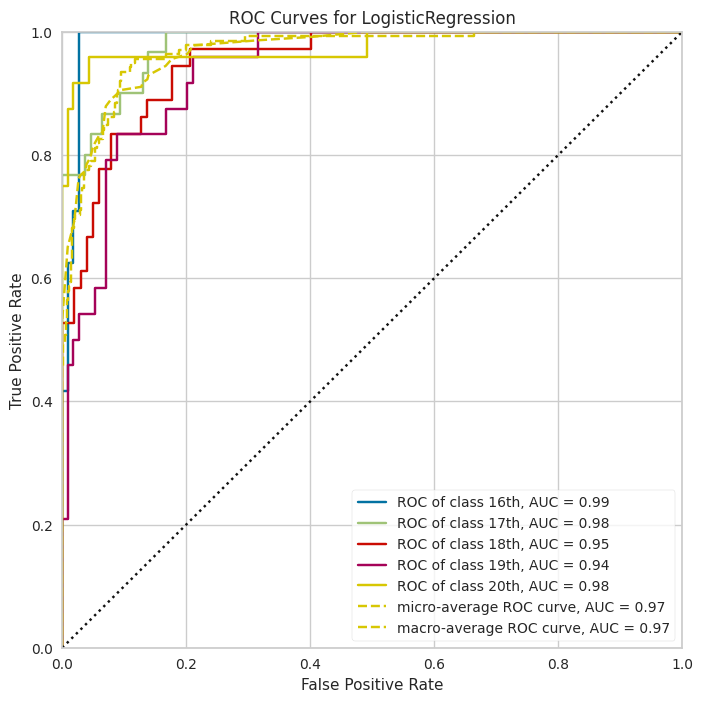

In [71]:
lr_tfidf500 = res_lr_tfidf500['estimator']

fig, ax = plt.subplots(figsize=(8,8))
roc_auc(lr_tfidf500, Xtr_cnt_500, np.ravel(y_train), Xte_cnt_500, np.ravel(y_test), classes=cls, ax=ax)
ax.set_xlim(-0.005, 1.005)
ax.set_ylim(-0.005, 1.01)
ax.set_title("ROC multiclase – LR tfidf_500 (test)")
fig.tight_layout()
plt.show()

El ROC multiclase del modelo de Regresión Logística en test muestra una separabilidad excelente, las curvas están muy próximas al vértice superior izquierdo y los AUC por clase oscilan entre 0.94 y 0.99 , con promedios macro y micro en torno a 0.97. Esto indica que el modelo ordena de forma muy fiable los ejemplos positivos por encima de los negativos en todas las clases, siendo 19th la más comprometida pero aún con un AUC alto.

## Conclusión global
Entre todos los modelos evaluados elegiría como modelo final la Regresión Logística con representación TF‑IDF de 500 términos. Aunque la variante binaria de 500 términos obtiene un F1 macro ligeramente superior (0.797 vs 0.795) y un accuracy marginalmente mayor (0.804 vs 0.797), la diferencia es mínima y TF‑IDF ofrece mayor robustez ante la incorporación de nuevo vocabulario al atenuar palabras muy frecuentes y resaltar las discriminativas. TF‑IDF mantiene altas métricas en las clases fáciles (16th, 17th, 20th), mejora sustancialmente 18th frente a Naïve Bayes y conserva un comportamiento competitivo en la clase difícil (19th), con matrices de confusión más equilibradas que las de conteos puros. Por tanto, priorizando generalización y escalabilidad, selecciono LR + TF‑IDF (500 términos) como el mejor compromiso entre rendimiento actual y estabilidad futura.